# Tensorflow practice C2W3 Inception V3

+ 전이학습

+ Data augmentation

In [2]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

In [3]:
#download inception model V3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


--2021-11-16 11:58:02--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 34.64.4.112, 34.64.4.80, 34.64.4.48, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|34.64.4.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: `/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

/tmp/inception_v3_w 100%[===================>]  83.84M  45.6MB/s    in 1.8s    

2021-11-16 11:58:04 (45.6 MB/s) - `/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5' saved [87910968/87910968]



In [4]:
# import inception model
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [5]:
# create an instance of the inception model
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150,150,3),
                               include_top = False,
                               weights = None)

pre_trained_model.load_weights(local_weights_file)

# make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
    layer.trainable = False

#print all layer's name
pre_trained_model.summary()

2021-11-16 12:00:29.496555: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-16 12:00:29.497470: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_________________________________________________________

In [6]:
# 위의 summary에서 나온 layer중 mixed7이라는 layer을 pre-trained model 의 마지막 layer로 지정
# (전이학습을 위함)
last_layer = pre_trained_model.get_layer('mixed7')
# output을 last_layer의 output으로 지정
last_output = last_layer.output

print(last_output.shape)

(None, 7, 7, 768)


In [7]:
# define callback 
class mycallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.999):
            print('\nReached 99.9% accuracy so cancelling training')
            self.model.stop_training=True
    

In [8]:
from tensorflow.keras.optimizers import RMSprop

#flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# add fully connected layer
x = layers.Dense(1024, activation='relu')(x)
# add dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# add final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer = RMSprop(learning_rate=0.0001),
             loss = 'binary_crossentropy',
             metrics= ['accuracy']
             )


In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
# Get the Horse or Human dataset
!gdown --id 1onaG42NZft3wCE1WH0GDEbUhu75fedP5

# Get the Horse or Human Validation dataset
!gdown --id 1LYeusSEIiZQpwN-mthh5nKdA75VsKG1U
  
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

test_local_zip = './horse-or-human.zip'
zip_ref = zipfile.ZipFile(test_local_zip, 'r')
zip_ref.extractall('./training')

val_local_zip = './validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(val_local_zip, 'r')
zip_ref.extractall('./validation')

zip_ref.close()

Downloading...
From: https://drive.google.com/uc?id=1onaG42NZft3wCE1WH0GDEbUhu75fedP5
To: /Users/jinwooahn/Documents/dev_folder/2021_2nd_semester/tensorflow_certificate/C2/W3/horse-or-human.zip
100%|████████████████████████████████████████| 150M/150M [00:08<00:00, 17.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1LYeusSEIiZQpwN-mthh5nKdA75VsKG1U
To: /Users/jinwooahn/Documents/dev_folder/2021_2nd_semester/tensorflow_certificate/C2/W3/validation-horse-or-human.zip
100%|██████████████████████████████████████| 11.5M/11.5M [00:01<00:00, 5.83MB/s]


In [13]:
train_dir = './training'
validation_dir = './validation'

train_horses_dir = os.path.join(train_dir, 'horses')
train_humans_dir = os.path.join(train_dir, 'humans')

validation_horses_dir = os.path.join(validation_dir ,'horses')
validation_humans_dir = os.path.join(validation_dir, 'humans')

train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)

validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

print(len(train_horses_fnames)) 
print(len(train_humans_fnames)) 
print(len(validation_horses_fnames)) 
print(len(validation_humans_fnames)) 

500
527
128
128


In [14]:
# add data augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255.,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

# validation data는 augmented되면 안된다!!
test_datagen = ImageDataGenerator(rescale=1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   batch_size=20,
                                                   class_mode='binary',
                                                   target_size=(150,150))

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                       batch_size=20,
                                                       class_mode='binary',
                                                       target_size=(150,150))


Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [17]:
callbacks = mycallback() 
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 10,
            epochs = 100,
            validation_steps = 5,
            verbose = 2,
            callbacks=callbacks)

Epoch 1/100
10/10 - 2s - loss: 0.0585 - accuracy: 0.9840 - val_loss: 0.1286 - val_accuracy: 0.9400
Epoch 2/100
10/10 - 2s - loss: 0.0852 - accuracy: 0.9600 - val_loss: 0.1718 - val_accuracy: 0.9300
Epoch 3/100
10/10 - 2s - loss: 0.0174 - accuracy: 0.9950 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 4/100
10/10 - 2s - loss: 0.0288 - accuracy: 0.9900 - val_loss: 0.0529 - val_accuracy: 0.9800
Epoch 5/100
10/10 - 1s - loss: 0.0228 - accuracy: 0.9947 - val_loss: 0.0176 - val_accuracy: 0.9900
Epoch 6/100
10/10 - 2s - loss: 0.0450 - accuracy: 0.9947 - val_loss: 0.0061 - val_accuracy: 1.0000
Epoch 7/100
10/10 - 2s - loss: 0.0204 - accuracy: 0.9950 - val_loss: 0.0250 - val_accuracy: 0.9800
Epoch 8/100
10/10 - 2s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000

Reached 99.9% accuracy so cancelling training


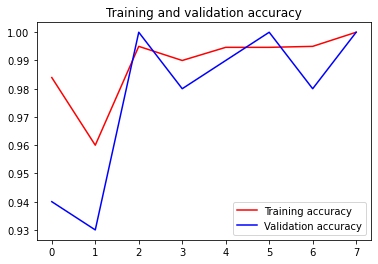

<Figure size 432x288 with 0 Axes>

In [18]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()